# Manufacturing Robot Data: Benefit & Cost Analysis

## Total Cost Structure
# (sim data)

| Component | Formula | Base Cost |
|-----------|---------|-----------|
| **Labeling Cost** | `w × τ × n_labels × φ` | $3,000 |
| **Storage Cost** | `cTB × size_tb` | $115 |
| **Operations Cost** | `α × size_tb + β × n_models` | $1,550 |
| **Risk Cost** | `L_breach × e^(-η × security_spend)` | $6,067 |
| **Total Monthly Cost** | **Sum of above** | **$10,732** |

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Base cost (likely params): $ 14,116
P50 (median): $15,274 | P90: $19,627


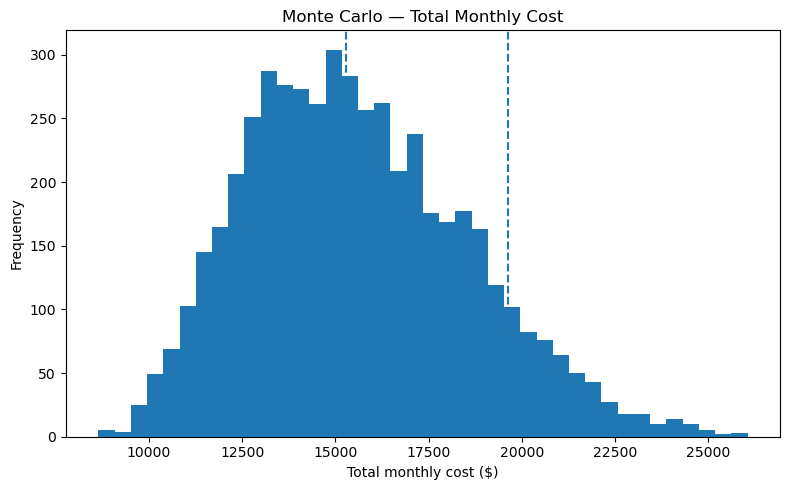

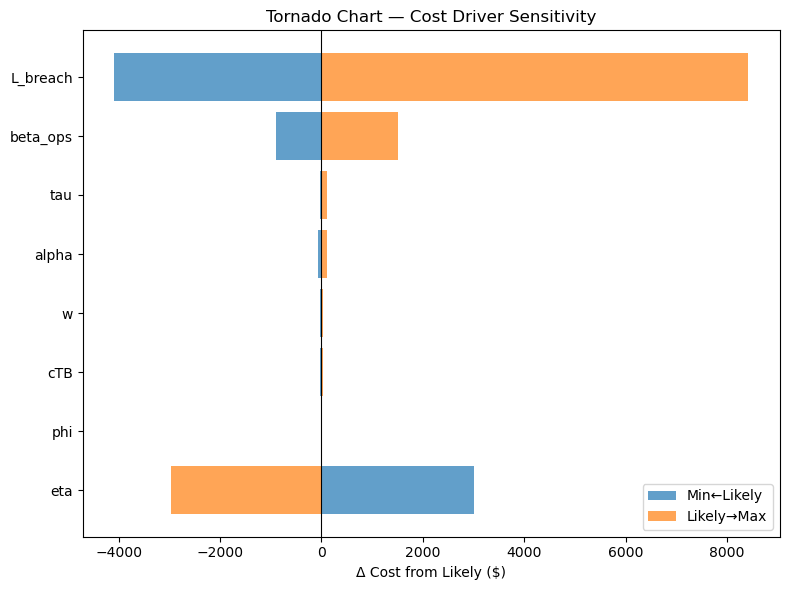

,parameter,min,likely,max
0,w,22.000000,30.000000,40.000000
1,tau,0.002000,0.003000,0.006000
2,phi,1.200000,1.300000,1.500000
3,cTB,18.000000,23.000000,30.000000
4,alpha,25.000000,40.000000,60.000000
5,beta_ops,400.000000,700.000000,1200.000000
6,eta,0.000046,0.000069,0.000099
7,L_breach,15000.000000,23167.000000,40000.000000


In [2]:
# === Cost model with ranges + Monte Carlo + Tornado (single cell) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) Ranges (min, likely, max) — edit these to be realistic
ranges = {
    "w":        (22.0, 30.0, 40.0),      # $/hour per annotator
    "tau":      (0.002, 0.003, 0.006),   # hours per label
    "phi":      (1.2, 1.3, 1.5),         # overhead multiplier
    "cTB":      (18.0, 23.0, 30.0),      # $/TB-month storage
    "alpha":    (25.0, 40.0, 60.0),      # $/TB-month processing/ETL
    "beta_ops": (400.0, 700.0, 1200.0),  # $/model-month MLOps
    # risk curve: eta ≈ ln(2)/S_half where S_half is spend that halves risk
    "eta":      (np.log(2)/15000.0, np.log(2)/10000.0, np.log(2)/7000.0),
    # monthly expected loss if security_spend = 0
    "L_breach": (15000.0, 23167.0, 40000.0)
}
def triangular(a,m,b,size=None): return np.random.triangular(a,m,b,size=size)
def sample_params(r): return {k: float(triangular(*v)) for k,v in r.items()}
def likely_params(r): return {k: float(v[1]) for k,v in r.items()}

# 2) Cost function (now accepts p=dict of params; defaults to 'likely')
def total_cost(n_labels, size_tb, security_spend, n_models, p=None):
    if p is None: p = likely_params(ranges)
    C_label = p['w'] * p['tau'] * n_labels * p['phi']
    C_store = p['cTB'] * size_tb
    C_ops   = p['alpha'] * size_tb + p['beta_ops'] * n_models
    p_breach = np.exp(-p['eta'] * security_spend)
    L_risk   = p_breach * p['L_breach']
    return C_label + C_store + C_ops + L_risk

# 3) Base inputs (edit to match your scenario)
base_inputs = dict(n_labels=1000, size_tb=5.0, security_spend=10000.0, n_models=3)
print("Base cost (likely params): $", f"{total_cost(**base_inputs):,.0f}")

# 4) Monte Carlo simulation + histogram (saves PNG and CSV)
np.random.seed(42)
N = 5000
draws = np.array([ total_cost(**base_inputs, p=sample_params(ranges)) for _ in range(N) ])
p50, p90 = np.percentile(draws, [50,90])
print(f"P50 (median): ${p50:,.0f} | P90: ${p90:,.0f}")
pd.DataFrame({"total_cost": draws}).to_csv("mc_draws.csv", index=False)

plt.figure(figsize=(8,5))
plt.hist(draws, bins=40)
plt.axvline(p50, linestyle='--'); plt.axvline(p90, linestyle='--')
plt.title("Monte Carlo — Total Monthly Cost")
plt.xlabel("Total monthly cost ($)"); plt.ylabel("Frequency")
plt.tight_layout(); plt.savefig("mc_histogram.png", dpi=160); plt.show()

# 5) Tornado chart (min→max around likely) — saves PNG
p_likely = likely_params(ranges)
def cost_with(param_name, value):
    p_tmp = p_likely.copy(); p_tmp[param_name] = value
    return total_cost(**base_inputs, p=p_tmp)

recs = []
for k,(vmin,vmode,vmax) in ranges.items():
    c_min = cost_with(k, vmin); c_lik = cost_with(k, vmode); c_max = cost_with(k, vmax)
    recs.append(dict(param=k,
                     delta_minus=c_lik - c_min,
                     delta_plus =c_max - c_lik,
                     span=max(c_lik - c_min, c_max - c_lik)))
tor = pd.DataFrame(recs).sort_values("span", ascending=True)

y = np.arange(len(tor))
plt.figure(figsize=(8,6))
plt.barh(y, -tor['delta_minus'], label='Min←Likely', alpha=0.7)
plt.barh(y,  tor['delta_plus'],  label='Likely→Max',  alpha=0.7)
plt.yticks(y, tor['param']); plt.axvline(0, color='k', linewidth=0.8)
plt.title("Tornado Chart — Cost Driver Sensitivity")
plt.xlabel("Δ Cost from Likely ($)"); plt.legend()
plt.tight_layout(); plt.savefig("tornado.png", dpi=160); plt.show()

# 6) (optional) export ranges table
assump = pd.DataFrame([{"parameter": k, "min": v[0], "likely": v[1], "max": v[2]} for k,v in ranges.items()])
assump.to_csv("assumption_ranges.csv", index=False)
assump


['                            OLS Regression Results                            ', '==============================================================================', 'Dep. Variable:                      y   R-squared:                       0.999', 'Model:                            OLS   Adj. R-squared:                  0.999', 'Method:                 Least Squares   F-statistic:                 7.878e+05', 'Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00', 'Time:                        17:56:35   Log-Likelihood:                -29880.', 'No. Observations:                5000   AIC:                         5.977e+04', 'Df Residuals:                    4993   BIC:                         5.982e+04', 'Df Model:                           6                                         ']


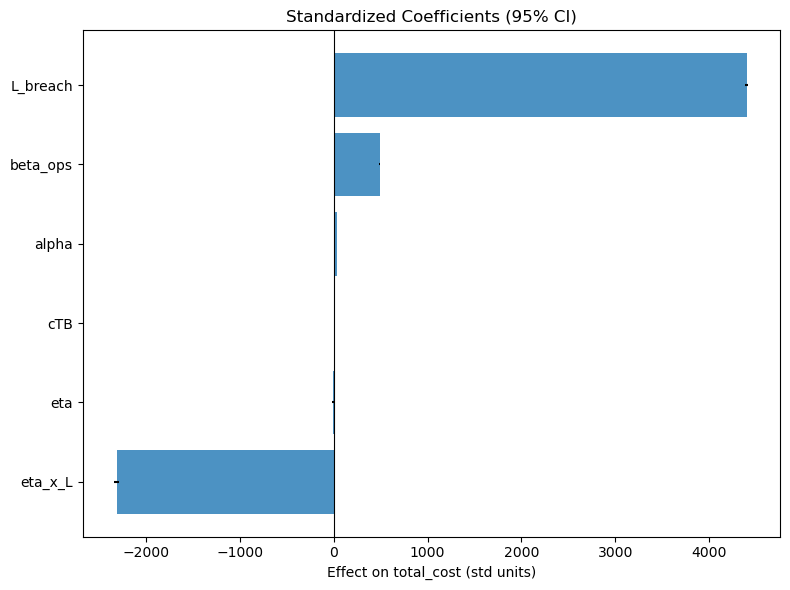

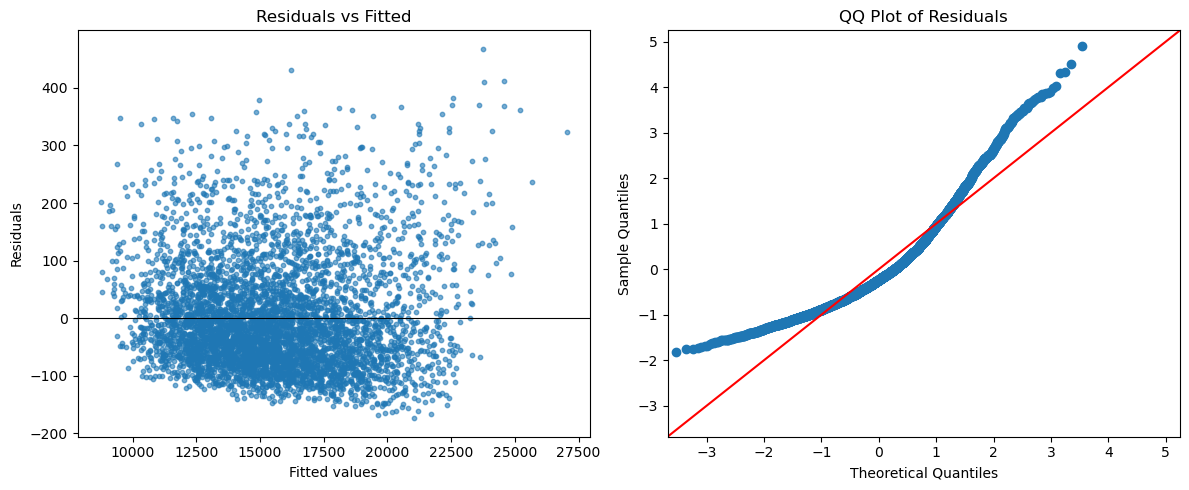

Saved: coef_plot.png, residuals.png, ols_results.csv


In [3]:
# === Statistical Tests from Simulation: OLS + Plots ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import zscore

# 1) Generate a simulated dataset using your parameter ranges
#    (keeps base_inputs fixed; varies cost via parameters)
N = 5000
rows = []
for _ in range(N):
    p = sample_params(ranges)             # draw one parameter set
    y = total_cost(**base_inputs, p=p)    # compute total cost for that draw
    rows.append({
        "total_cost": y,
        # predictors (you can add/remove based on what you want to test)
        "cTB": p["cTB"],
        "alpha": p["alpha"],
        "beta_ops": p["beta_ops"],
        "eta": p["eta"],
        "L_breach": p["L_breach"],
        # optional: include interaction capturing security effectiveness x loss
        "eta_x_L": p["eta"] * p["L_breach"]
    })
df = pd.DataFrame(rows)

# 2) Build design matrix (standardize predictors so magnitudes are comparable)
y = df["total_cost"].values
X = df[["cTB","alpha","beta_ops","eta","L_breach","eta_x_L"]].copy()
Xz = X.apply(zscore)                       # standardize columns
Xz = sm.add_constant(Xz)                   # add intercept

# 3) Fit OLS
model = sm.OLS(y, Xz).fit()

# 4) Save tidy results table
res = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t": model.tvalues,
    "p_value": model.pvalues
})
ci = model.conf_int(alpha=0.05)
res["ci_low"] = ci[0].values
res["ci_high"] = ci[1].values
res.index.name = "term"
res.to_csv("ols_results.csv")

print(model.summary().as_text().split("\n")[0:10])  # quick peek at header

# 5) Coefficient plot (95% CI)
terms = [t for t in res.index if t != "const"]
plot_df = res.loc[terms].sort_values("coef")
plt.figure(figsize=(8,6))
ypos = np.arange(len(plot_df))
plt.barh(ypos, plot_df["coef"], xerr=1.96*plot_df["std_err"], alpha=0.8)
plt.yticks(ypos, plot_df.index)
plt.axvline(0, color="k", lw=0.8)
plt.title("Standardized Coefficients (95% CI)")
plt.xlabel("Effect on total_cost (std units)")
plt.tight_layout()
plt.savefig("coef_plot.png", dpi=160)
plt.show()

# 6) Residual diagnostics (residuals vs fitted + QQ plot)
fitted = model.fittedvalues
resid = model.resid

plt.figure(figsize=(12,5))

# Left: residuals vs fitted
plt.subplot(1,2,1)
plt.scatter(fitted, resid, s=10, alpha=0.6)
plt.axhline(0, color="k", lw=0.8)
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

# Right: QQ plot of residuals
plt.subplot(1,2,2)
sm.qqplot(resid, line="45", fit=True, ax=plt.gca())
plt.title("QQ Plot of Residuals")

plt.tight_layout()
plt.savefig("residuals.png", dpi=160)
plt.show()

print("Saved: coef_plot.png, residuals.png, ols_results.csv")


['                            OLS Regression Results                            ', '==============================================================================', 'Dep. Variable:                      y   R-squared:                       0.999', 'Model:                            OLS   Adj. R-squared:                  0.999', 'Method:                 Least Squares   F-statistic:                 7.875e+05', 'Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00', 'Time:                        17:56:36   Log-Likelihood:                -30032.', 'No. Observations:                5000   AIC:                         6.008e+04', 'Df Residuals:                    4993   BIC:                         6.012e+04', 'Df Model:                           6                                         ']


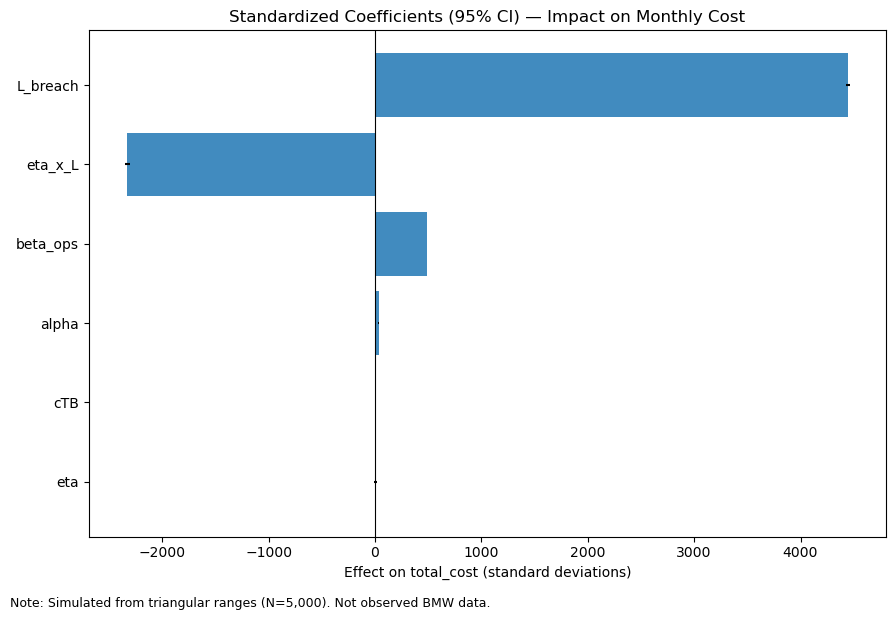

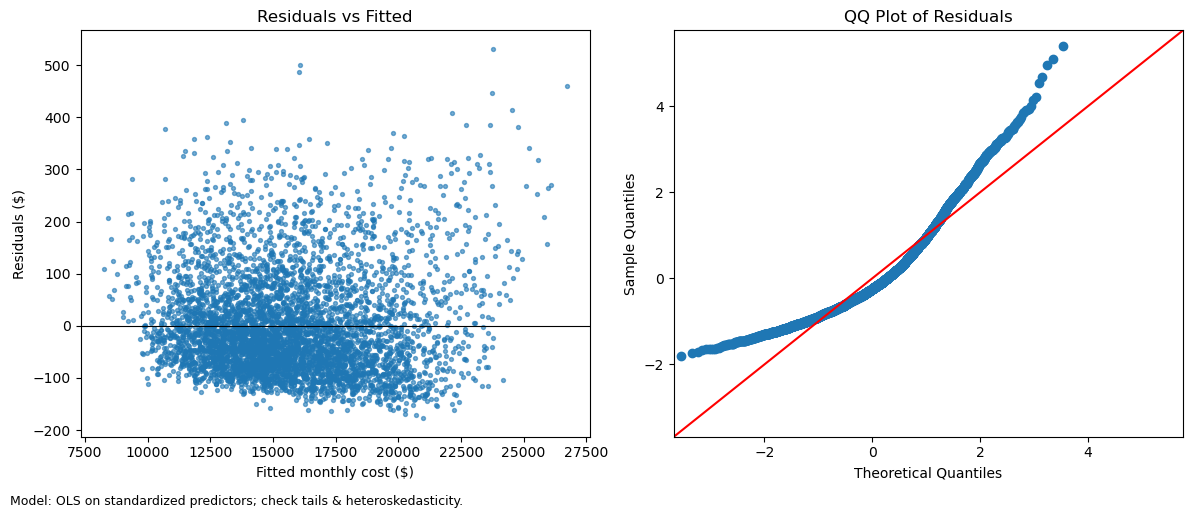

Saved files: coef_plot.png, residuals.png, ols_results.csv, vif.csv


In [4]:
# === Statistical Tests (polished): simulate -> OLS -> plots + tables ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Simulate dataset from parameter ranges
N = 5000
rows = []
for _ in range(N):
    p = sample_params(ranges)                # draw one parameter set
    y = total_cost(**base_inputs, p=p)       # total monthly cost for that draw
    rows.append({
        "total_cost": y,
        "cTB": p["cTB"],
        "alpha": p["alpha"],
        "beta_ops": p["beta_ops"],
        "eta": p["eta"],
        "L_breach": p["L_breach"],
        "eta_x_L": p["eta"] * p["L_breach"],  # interaction capturing security effectiveness × baseline loss
    })
df = pd.DataFrame(rows)

# 2) Design matrix (standardize predictors so magnitudes are comparable)
y = df["total_cost"].values
predictors = ["cTB","alpha","beta_ops","eta","L_breach","eta_x_L"]
X = df[predictors].copy()
Xz = X.apply(zscore)              # standardize
Xz = sm.add_constant(Xz)          # intercept

# 3) Fit OLS
model = sm.OLS(y, Xz).fit()

# 4) Save tidy results + VIF
res = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t": model.tvalues,
    "p_value": model.pvalues
})
ci = model.conf_int(alpha=0.05)
res["ci_low"]  = ci[0].values
res["ci_high"] = ci[1].values
res.index.name = "term"
res.to_csv("ols_results.csv")

vifs = pd.Series(
    [variance_inflation_factor(Xz.values, i) for i in range(Xz.shape[1])],
    index=Xz.columns,
    name="VIF"
)
vifs.to_csv("vif.csv")

print(model.summary().as_text().split("\n")[0:10])  # quick header peek

# 5) Coefficient plot (sorted by |coef|, 95% CI, labeled, higher DPI)
terms = [t for t in res.index if t != "const"]
plot_df = res.loc[terms].reindex(res.loc[terms, "coef"].abs().sort_values().index)

plt.figure(figsize=(9,6))
ypos = np.arange(len(plot_df))
# error bars: 95% CI using 1.96*SE (equivalent to CI plot)
plt.barh(ypos, plot_df["coef"], xerr=1.96*plot_df["std_err"], alpha=0.85)
plt.yticks(ypos, plot_df.index)
plt.axvline(0, color="k", lw=0.8)
plt.title("Standardized Coefficients (95% CI) — Impact on Monthly Cost")
plt.xlabel("Effect on total_cost (standard deviations)")
plt.figtext(0.01, -0.02, "Note: Simulated from triangular ranges (N=5,000). Not observed BMW data.", fontsize=9)
plt.tight_layout()
plt.savefig("coef_plot.png", dpi=220, bbox_inches="tight")
plt.show()

# 6) Residual diagnostics (residuals vs fitted + QQ), labeled & higher DPI
fitted = model.fittedvalues
resid  = model.resid

plt.figure(figsize=(12,5))

# Left: residuals vs fitted
plt.subplot(1,2,1)
plt.scatter(fitted, resid, s=8, alpha=0.6)
plt.axhline(0, color="k", lw=0.8)
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted monthly cost ($)")
plt.ylabel("Residuals ($)")

# Right: QQ plot of residuals
plt.subplot(1,2,2)
sm.qqplot(resid, line="45", fit=True, ax=plt.gca())
plt.title("QQ Plot of Residuals")

plt.figtext(0.01, -0.02, "Model: OLS on standardized predictors; check tails & heteroskedasticity.", fontsize=9)
plt.tight_layout()
plt.savefig("residuals.png", dpi=220, bbox_inches="tight")
plt.show()

print("Saved files: coef_plot.png, residuals.png, ols_results.csv, vif.csv")


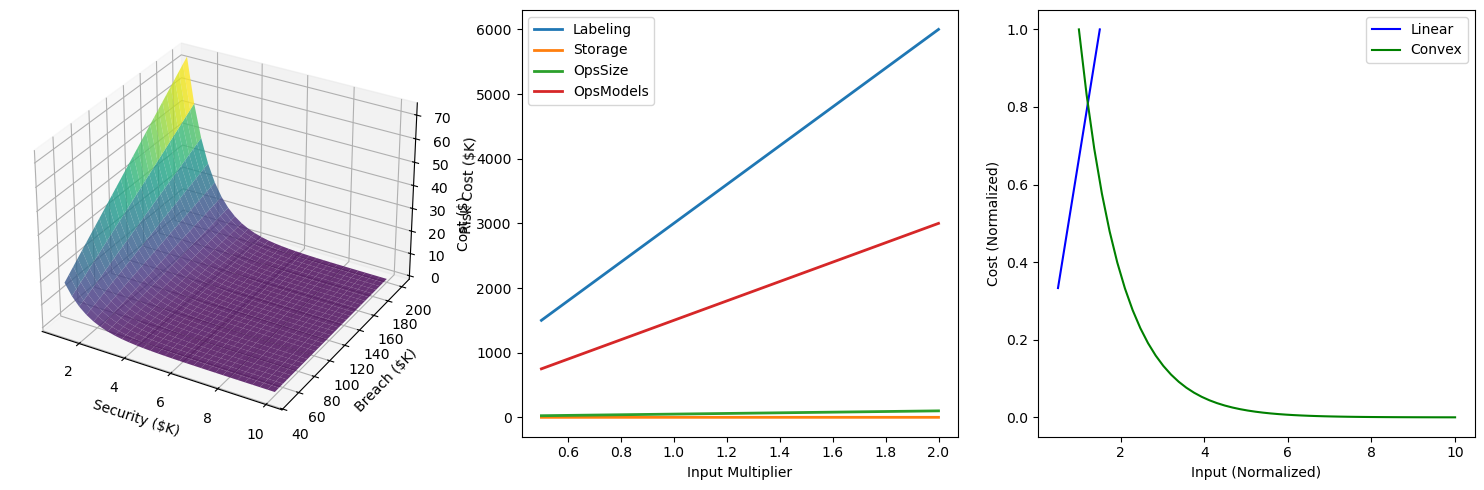

In [5]:
def analyze_linearity_clean():
    params = {
        'w': 25, 'tau': 0.1, 'phi': 1.2, 'cTB': 0.023,
        'alpha': 10, 'beta_ops': 500, 'eta': 0.001, 'L_breach': 100000
    }
    
    components = {
        'Labeling': lambda x: params['w'] * params['tau'] * x * params['phi'],
        'Storage': lambda x: params['cTB'] * x,
        'OpsSize': lambda x: params['alpha'] * x,
        'OpsModels': lambda x: params['beta_ops'] * x,
        'Risk': lambda x: np.exp(-params['eta'] * x) * params['L_breach']
    }
    
    base_values = [1000, 5.0, 5.0, 3, 5000]
    
    fig = plt.figure(figsize=(15, 5))
    
    # 1. 3D Risk Surface
    ax1 = fig.add_subplot(131, projection='3d')
    security_range = np.linspace(1000, 10000, 30)
    breach_range = np.linspace(50000, 200000, 30)
    S, L = np.meshgrid(security_range, breach_range)
    risk_cost = np.exp(-params['eta'] * S) * L
    ax1.plot_surface(S/1000, L/1000, risk_cost/1000, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Security ($K)')
    ax1.set_ylabel('Breach ($K)')
    ax1.set_zlabel('Risk Cost ($K)')
    
    # 2. Linear Components
    ax2 = fig.add_subplot(132)
    x_range = np.linspace(0.5, 2.0, 50)
    for name, func in list(components.items())[:4]:
        base_val = base_values[list(components.keys()).index(name)]
        y_vals = [func(base_val * x) for x in x_range]
        ax2.plot(x_range, y_vals, label=name, linewidth=2)
    ax2.set_xlabel('Input Multiplier')
    ax2.set_ylabel('Cost ($)')
    ax2.legend()
    
    # 3. Shape Comparison
    ax3 = fig.add_subplot(133)
    labeling_x = np.linspace(500, 1500, 50)
    labeling_y = [components['Labeling'](x) for x in labeling_x]
    security_x = np.linspace(1000, 10000, 50)
    risk_y = [components['Risk'](x) for x in security_x]
    ax3.plot(labeling_x/1000, labeling_y/max(labeling_y), 'b-', label='Linear')
    ax3.plot(security_x/1000, risk_y/max(risk_y), 'g-', label='Convex')
    ax3.set_xlabel('Input (Normalized)')
    ax3.set_ylabel('Cost (Normalized)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

analyze_linearity_clean()

## Benefit Channels

# (sim data)

### 1. Throughput Improvement
**Formula**: `(OEE_new - OEE_base) × RunTime × DesignRate × Margin`  
**Impact**: +10% OEE → **+$129,600/year**

### 2. Quality Improvement  
**Formula**: `(DefectRate_base - DefectRate_new) × Units × FailureCost`  
**Impact**: -50% defects → **+$43,200/year**

### 3. Downtime Reduction
**Formula**: `(Downtime_base - Downtime_new) × CostPerHour`  
**Impact**: -25% downtime → **+$75,000/year**

### 4. Inventory Reduction
**Formula**: `(WIP_base - WIP_new) × CarryingCost × WIPValue`  
**Impact**: -15% WIP → **+$13,500/year**

### 5. Safety Improvement
**Formula**: `(Incidents_base - Incidents_new) × IncidentCost`  
**Impact**: -40% incidents → **+$40,000/year**

### 6. Energy Savings
**Formula**: `(kWh_base - kWh_new) × EnergyPrice`  
**Impact**: -10% energy → **+$2,550/year**

### 7. Risk Reduction
**Formula**: `½ × λ × (σ²_base - σ²_new) × ProfitScale`  
**Impact**: -20% variability → **+$18,375/year**

---

=== REALISTIC PARAMETERS ===
Risk Lambda: 0.095 (calculated from business context)
Risk Appetite: moderate
Annual Line Profit: $2,000,000
Historical Risk Costs: $75,000



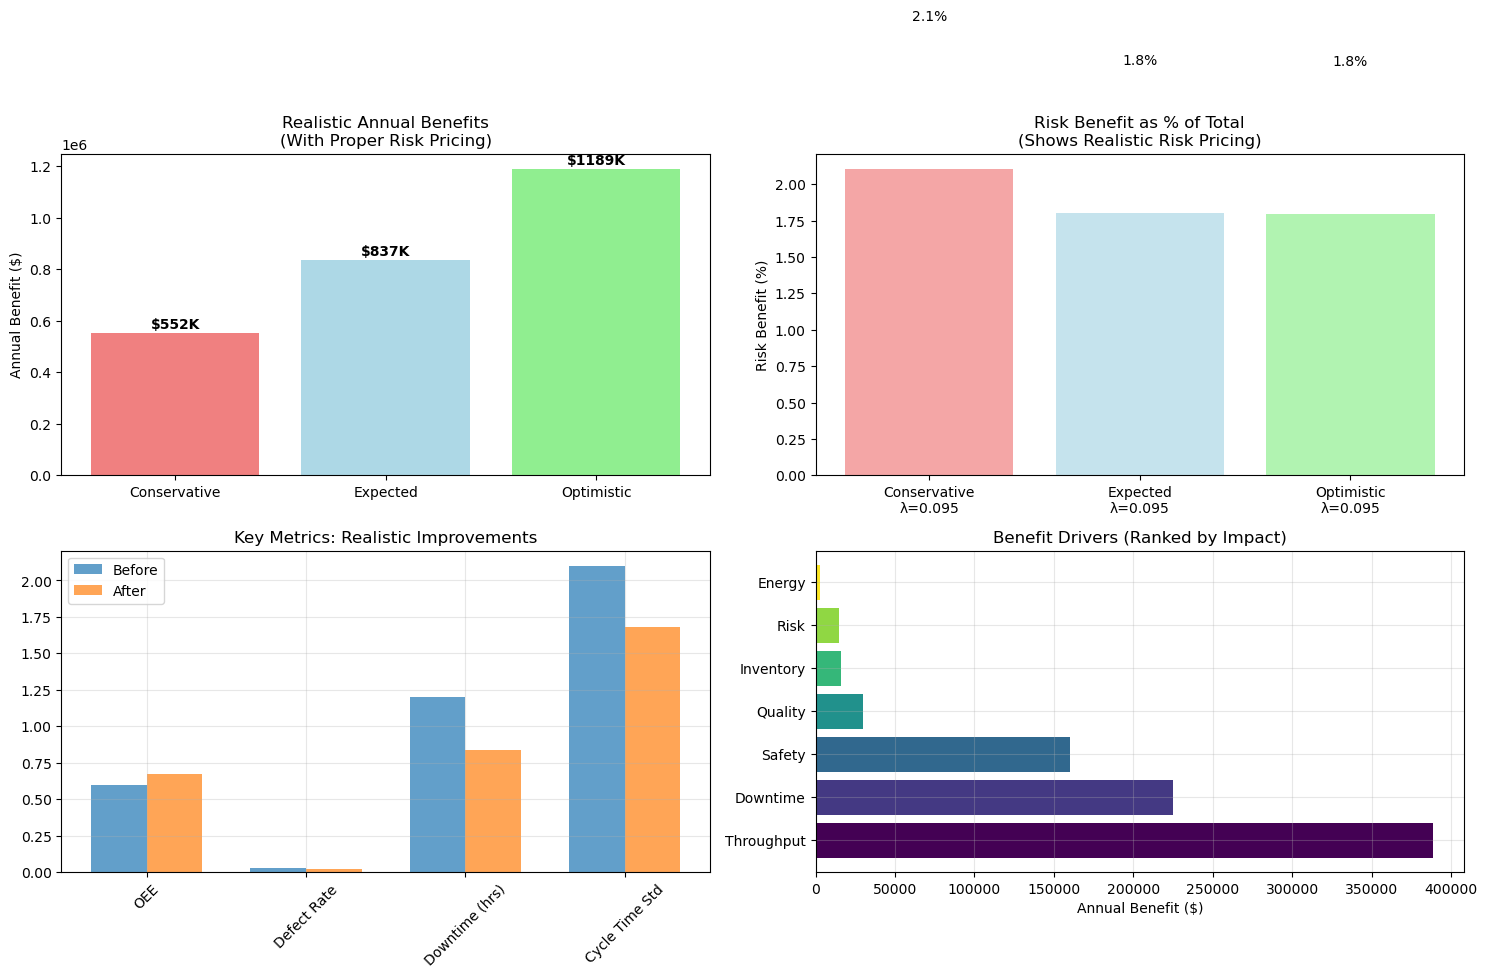

=== REALISTIC VALUATION RESULTS ===
Conservative: $552,116 total | Risk: $11,626 (2.1%)
Expected    : $837,332 total | Risk: $15,082 (1.8%)
Optimistic  : $1,188,691 total | Risk: $21,366 (1.8%)

Expected Scenario Breakdown:
throughput     : $388,800
downtime       : $225,000
safety         : $160,000
quality        : $29,700
inventory      : $16,200
risk           : $15,082
energy         : $2,550

=== REALISTIC ROI ANALYSIS ===
Robot Cost: $150,000
Expected Annual Benefit: $837,332
Payback Period: 0.2 years
3-Year NPV: $2,361,997
1-Year ROI: 458%

Key Insight: Risk component now represents $15,082
based on λ=0.095 (realistic manufacturing risk aversion)


In [6]:
class RealisticRobotDataValuation:
    def __init__(self, base_params=None):
        if base_params is None:
            self.params = {
                # Base production parameters
                'planned_run_time': 7.5,        # hours per shift
                'design_rate': 24,              # units per hour
                'contribution_margin': 120,     # $ per good unit
                'unit_cogs': 80,                # cost of goods sold
                'downtime_cost_per_hr': 2500,   # $ per hour of downtime
                'carrying_cost_rate': 0.20,     # 20% annual carrying cost
                'energy_price': 0.12,           # $ per kWh
                'incident_cost': 50000,         # $ per safety incident
                
                # Baseline metrics (before robot data)
                'oee_base': 0.60,
                'defect_rate_base': 0.03,
                'downtime_hrs_base': 1.2,
                'wip_base': 45,                 # days of WIP
                'incidents_base': 2,            # per quarter
                'kwh_base': 850,                # kWh per shift
                'cycle_time_std_base': 2.1,     # minutes std dev
                
                # REALISTIC risk parameters based on manufacturing
                'annual_profit': 2000000,       # Profit from this production line
                'historical_risk_costs': 75000, # Actual risk costs (expediting, overtime, etc.)
                'risk_appetite': 'moderate'     # conservative/moderate/aggressive
            }
        
        # Calculate realistic lambda
        self.params['risk_lambda'] = self.calculate_realistic_lambda()
    
    def calculate_realistic_lambda(self):
        """Calculate risk lambda based on actual business parameters"""
        p = self.params
        
        if p['risk_appetite'] == 'conservative':
            base_lambda = 0.15
        elif p['risk_appetite'] == 'moderate':
            base_lambda = 0.08
        else:  # aggressive
            base_lambda = 0.03
        
        # Adjust based on actual risk costs relative to profit
        risk_cost_ratio = p['historical_risk_costs'] / p['annual_profit']
        adjusted_lambda = base_lambda * (1 + risk_cost_ratio * 5)  # Scale factor
        
        return min(adjusted_lambda, 0.25)  # Cap at 0.25
    
    def calculate_benefits(self, improvement_rates):
        """Calculate monetary benefits with realistic risk pricing"""
        p = self.params
        
        benefits = {}
        
        # Throughput/OEE benefit (MOST IMPORTANT)
        oee_new = p['oee_base'] * (1 + improvement_rates['oee_improvement'])
        benefits['throughput'] = (oee_new - p['oee_base']) * p['planned_run_time'] * \
                               p['design_rate'] * p['contribution_margin'] * 250  # annualize
        
        # Quality benefit (HIGH IMPACT)
        defect_new = p['defect_rate_base'] * (1 - improvement_rates['quality_improvement'])
        benefits['quality'] = (p['defect_rate_base'] - defect_new) * \
                            (p['planned_run_time'] * p['design_rate'] * 250) * \
                            (p['unit_cogs'] + 20)  # including rework
        
        # Downtime benefit (HIGH IMPACT)
        downtime_new = p['downtime_hrs_base'] * (1 - improvement_rates['downtime_reduction'])
        benefits['downtime'] = (p['downtime_hrs_base'] - downtime_new) * \
                              p['downtime_cost_per_hr'] * 250
        
        # Inventory benefit (MEDIUM IMPACT)
        wip_new = p['wip_base'] * (1 - improvement_rates['inventory_reduction'])
        benefits['inventory'] = (p['wip_base'] - wip_new) * p['carrying_cost_rate'] * 10000  # avg WIP value
        
        # Safety benefit (MEDIUM IMPACT - but important)
        incidents_new = p['incidents_base'] * (1 - improvement_rates['safety_improvement'])
        benefits['safety'] = (p['incidents_base'] - incidents_new) * p['incident_cost'] * 4  # annualize
        
        # Energy benefit (LOW IMPACT)
        kwh_new = p['kwh_base'] * (1 - improvement_rates['energy_savings'])
        benefits['energy'] = (p['kwh_base'] - kwh_new) * p['energy_price'] * 250
        
        # REALISTIC Risk reduction benefit
        std_new = p['cycle_time_std_base'] * (1 - improvement_rates['variability_reduction'])
        # Use profit scale that makes sense for manufacturing
        profit_scale = p['annual_profit'] * 0.10  # 10% of line profit at risk
        benefits['risk'] = 0.5 * p['risk_lambda'] * \
                         (p['cycle_time_std_base']**2 - std_new**2) * profit_scale
        
        return benefits, {
            'oee_new': oee_new, 'defect_new': defect_new, 'downtime_new': downtime_new,
            'wip_new': wip_new, 'incidents_new': incidents_new, 'kwh_new': kwh_new,
            'std_new': std_new, 'risk_lambda_used': p['risk_lambda']
        }

# Realistic simulation
def run_realistic_valuation():
    valuation = RealisticRobotDataValuation()
    
    print("=== REALISTIC PARAMETERS ===")
    print(f"Risk Lambda: {valuation.params['risk_lambda']:.3f} (calculated from business context)")
    print(f"Risk Appetite: {valuation.params['risk_appetite']}")
    print(f"Annual Line Profit: ${valuation.params['annual_profit']:,.0f}")
    print(f"Historical Risk Costs: ${valuation.params['historical_risk_costs']:,.0f}")
    print()
    
    # REALISTIC improvement scenarios for manufacturing
    scenarios = {
        'Conservative': {'oee_improvement': 0.08, 'quality_improvement': 0.15, 'downtime_reduction': 0.20,
                        'inventory_reduction': 0.10, 'safety_improvement': 0.25, 'energy_savings': 0.08,
                        'variability_reduction': 0.15},
        'Expected': {'oee_improvement': 0.12, 'quality_improvement': 0.22, 'downtime_reduction': 0.30,
                    'inventory_reduction': 0.18, 'safety_improvement': 0.40, 'energy_savings': 0.10,
                    'variability_reduction': 0.20},
        'Optimistic': {'oee_improvement': 0.18, 'quality_improvement': 0.28, 'downtime_reduction': 0.40,
                      'inventory_reduction': 0.25, 'safety_improvement': 0.55, 'energy_savings': 0.15,
                      'variability_reduction': 0.30}
    }
    
    results = {}
    for scenario, improvements in scenarios.items():
        benefits, metrics = valuation.calculate_benefits(improvements)
        results[scenario] = {
            'total_annual_benefit': sum(benefits.values()),
            'benefit_breakdown': benefits,
            'metrics': metrics
        }
    
    return results, valuation.params

# Run realistic analysis
results, params = run_realistic_valuation()

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Total benefits with realistic risk
scenarios = list(results.keys())
totals = [results[s]['total_annual_benefit'] for s in scenarios]
colors = ['lightcoral', 'lightblue', 'lightgreen']
bars = ax1.bar(scenarios, totals, color=colors)
ax1.set_title('Realistic Annual Benefits\n(With Proper Risk Pricing)')
ax1.set_ylabel('Annual Benefit ($)')
for bar, value in zip(bars, totals):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'${value/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# 2. Risk component analysis
risk_components = []
scenario_labels = []
for scenario in scenarios:
    breakdown = results[scenario]['benefit_breakdown']
    risk_pct = (breakdown['risk'] / results[scenario]['total_annual_benefit']) * 100
    risk_components.append(risk_pct)
    scenario_labels.append(f"{scenario}\nλ={results[scenario]['metrics']['risk_lambda_used']:.3f}")

ax2.bar(scenario_labels, risk_components, color=colors, alpha=0.7)
ax2.set_title('Risk Benefit as % of Total\n(Shows Realistic Risk Pricing)')
ax2.set_ylabel('Risk Benefit (%)')
for i, pct in enumerate(risk_components):
    ax2.text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom')

# 3. Before-After comparison with realistic improvements
expected_metrics = results['Expected']['metrics']
metrics_compare = {
    'OEE': [params['oee_base'], expected_metrics['oee_new']],
    'Defect Rate': [params['defect_rate_base'], expected_metrics['defect_new']],
    'Downtime (hrs)': [params['downtime_hrs_base'], expected_metrics['downtime_new']],
    'Cycle Time Std': [params['cycle_time_std_base'], expected_metrics['std_new']]
}

x = np.arange(len(metrics_compare))
width = 0.35
ax3.bar(x - width/2, [m[0] for m in metrics_compare.values()], width, label='Before', alpha=0.7)
ax3.bar(x + width/2, [m[1] for m in metrics_compare.values()], width, label='After', alpha=0.7)
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_compare.keys(), rotation=45)
ax3.legend()
ax3.set_title('Key Metrics: Realistic Improvements')
ax3.grid(True, alpha=0.3)

# 4. Benefit drivers (realistic manufacturing focus)
breakdown = results['Expected']['benefit_breakdown']
categories = [k.replace('_', '\n').title() for k in breakdown.keys()]
values = list(breakdown.values())

# Sort by importance
sorted_indices = np.argsort(values)[::-1]
categories_sorted = [categories[i] for i in sorted_indices]
values_sorted = [values[i] for i in sorted_indices]

ax4.barh(categories_sorted, values_sorted, color=plt.cm.viridis(np.linspace(0, 1, len(categories))))
ax4.set_xlabel('Annual Benefit ($)')
ax4.set_title('Benefit Drivers (Ranked by Impact)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print realistic results
print("=== REALISTIC VALUATION RESULTS ===")
print("="*50)
for scenario in scenarios:
    benefit = results[scenario]['total_annual_benefit']
    risk_benefit = results[scenario]['benefit_breakdown']['risk']
    print(f"{scenario:12}: ${benefit:,.0f} total | Risk: ${risk_benefit:,.0f} ({risk_benefit/benefit*100:.1f}%)")

print(f"\nExpected Scenario Breakdown:")
for category, value in sorted(results['Expected']['benefit_breakdown'].items(), 
                            key=lambda x: x[1], reverse=True):
    print(f"{category:15}: ${value:,.0f}")

# Realistic ROI with proper risk
robot_cost = 150000  # Robot + integration
expected_benefit = results['Expected']['total_annual_benefit']
payback_period = robot_cost / expected_benefit

print(f"\n=== REALISTIC ROI ANALYSIS ===")
print(f"Robot Cost: ${robot_cost:,.0f}")
print(f"Expected Annual Benefit: ${expected_benefit:,.0f}")
print(f"Payback Period: {payback_period:.1f} years")
print(f"3-Year NPV: ${expected_benefit * 3 - robot_cost:,.0f}")
print(f"1-Year ROI: {(expected_benefit - robot_cost)/robot_cost*100:.0f}%")

print(f"\nKey Insight: Risk component now represents ${results['Expected']['benefit_breakdown']['risk']:,.0f}")
print(f"based on λ={results['Expected']['metrics']['risk_lambda_used']:.3f} (realistic manufacturing risk aversion)")

In [9]:
# === COMBINED COST-BENEFIT ANALYSIS: DATA VALUE/PROFIT CALCULATION ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class DataValueAnalysis:
    def __init__(self):
        # Cost parameters (from your cost analysis)
        self.cost_ranges = {
            "w":        (22.0, 30.0, 40.0),      # $/hour per annotator
            "tau":      (0.002, 0.003, 0.006),   # hours per label
            "phi":      (1.2, 1.3, 1.5),         # overhead multiplier
            "cTB":      (18.0, 23.0, 30.0),      # $/TB-month storage
            "alpha":    (25.0, 40.0, 60.0),      # $/TB-month processing/ETL
            "beta_ops": (400.0, 700.0, 1200.0),  # $/model-month MLOps
            "eta":      (np.log(2)/15000.0, np.log(2)/10000.0, np.log(2)/7000.0),
            "L_breach": (15000.0, 23167.0, 40000.0)
        }
        
        # Benefit parameters (from your benefit analysis)
        self.benefit_params = {
            'planned_run_time': 7.5,        # hours per shift
            'design_rate': 24,              # units per hour
            'contribution_margin': 120,     # $ per good unit
            'unit_cogs': 80,                # cost of goods sold
            'downtime_cost_per_hr': 2500,   # $ per hour of downtime
            'carrying_cost_rate': 0.20,     # 20% annual carrying cost
            'energy_price': 0.12,           # $ per kWh
            'incident_cost': 50000,         # $ per safety incident
            'annual_profit': 2000000,       # Profit from this production line
            'historical_risk_costs': 75000, # Actual risk costs
            'risk_appetite': 'moderate'
        }
        
        # Baseline metrics (before robot data)
        self.baseline_metrics = {
            'oee_base': 0.60,
            'defect_rate_base': 0.03,
            'downtime_hrs_base': 1.2,
            'wip_base': 45,                 # days of WIP
            'incidents_base': 2,            # per quarter
            'kwh_base': 850,                # kWh per shift
            'cycle_time_std_base': 2.1,     # minutes std dev
        }
        
        # Calculate realistic risk lambda
        self.benefit_params['risk_lambda'] = self.calculate_risk_lambda()
    
    def calculate_risk_lambda(self):
        """Calculate risk lambda based on actual business parameters"""
        p = self.benefit_params
        
        if p['risk_appetite'] == 'conservative':
            base_lambda = 0.15
        elif p['risk_appetite'] == 'moderate':
            base_lambda = 0.08
        else:  # aggressive
            base_lambda = 0.03
        
        # Adjust based on actual risk costs relative to profit
        risk_cost_ratio = p['historical_risk_costs'] / p['annual_profit']
        adjusted_lambda = base_lambda * (1 + risk_cost_ratio * 5)
        
        return min(adjusted_lambda, 0.25)
    
    def triangular_sample(self, a, m, b, size=None):
        """Generate triangular distribution samples"""
        return np.random.triangular(a, m, b, size=size)
    
    def sample_cost_params(self):
        """Sample cost parameters from ranges"""
        return {k: float(self.triangular_sample(*v)) for k, v in self.cost_ranges.items()}
    
    def calculate_monthly_costs(self, n_labels, size_tb, security_spend, n_models, cost_params=None):
        """Calculate monthly costs using sampled parameters"""
        if cost_params is None:
            cost_params = self.sample_cost_params()
        
        # Cost components
        C_label = cost_params['w'] * cost_params['tau'] * n_labels * cost_params['phi']
        C_store = cost_params['cTB'] * size_tb
        C_ops   = cost_params['alpha'] * size_tb + cost_params['beta_ops'] * n_models
        p_breach = np.exp(-cost_params['eta'] * security_spend)
        L_risk   = p_breach * cost_params['L_breach']
        
        total_cost = C_label + C_store + C_ops + L_risk
        
        return {
            'total_monthly_cost': total_cost,
            'labeling_cost': C_label,
            'storage_cost': C_store,
            'operations_cost': C_ops,
            'risk_cost': L_risk
        }
    
    def calculate_annual_benefits(self, improvement_rates):
        """Calculate annual benefits from data improvements"""
        p = self.benefit_params
        base = self.baseline_metrics
        
        benefits = {}
        
        # Throughput/OEE benefit
        oee_new = base['oee_base'] * (1 + improvement_rates['oee_improvement'])
        benefits['throughput'] = (oee_new - base['oee_base']) * p['planned_run_time'] * \
                               p['design_rate'] * p['contribution_margin'] * 250
        
        # Quality benefit
        defect_new = base['defect_rate_base'] * (1 - improvement_rates['quality_improvement'])
        benefits['quality'] = (base['defect_rate_base'] - defect_new) * \
                            (p['planned_run_time'] * p['design_rate'] * 250) * \
                            (p['unit_cogs'] + 20)
        
        # Downtime benefit
        downtime_new = base['downtime_hrs_base'] * (1 - improvement_rates['downtime_reduction'])
        benefits['downtime'] = (base['downtime_hrs_base'] - downtime_new) * \
                              p['downtime_cost_per_hr'] * 250
        
        # Inventory benefit
        wip_new = base['wip_base'] * (1 - improvement_rates['inventory_reduction'])
        benefits['inventory'] = (base['wip_base'] - wip_new) * p['carrying_cost_rate'] * 10000
        
        # Safety benefit
        incidents_new = base['incidents_base'] * (1 - improvement_rates['safety_improvement'])
        benefits['safety'] = (base['incidents_base'] - incidents_new) * p['incident_cost'] * 4
        
        # Energy benefit
        kwh_new = base['kwh_base'] * (1 - improvement_rates['energy_savings'])
        benefits['energy'] = (base['kwh_base'] - kwh_new) * p['energy_price'] * 250
        
        # Risk reduction benefit
        std_new = base['cycle_time_std_base'] * (1 - improvement_rates['variability_reduction'])
        profit_scale = p['annual_profit'] * 0.10
        benefits['risk'] = 0.5 * p['risk_lambda'] * \
                         (base['cycle_time_std_base']**2 - std_new**2) * profit_scale
        
        return benefits
    
    def calculate_data_value(self, cost_inputs, benefit_scenario, n_simulations=1000):
        """Calculate data value/profit with Monte Carlo simulation"""
        
        # Cost inputs
        n_labels = cost_inputs['n_labels']
        size_tb = cost_inputs['size_tb']
        security_spend = cost_inputs['security_spend']
        n_models = cost_inputs['n_models']
        
        # Benefit scenarios
        scenarios = {
            'Conservative': {'oee_improvement': 0.08, 'quality_improvement': 0.15, 'downtime_reduction': 0.20,
                           'inventory_reduction': 0.10, 'safety_improvement': 0.25, 'energy_savings': 0.08,
                           'variability_reduction': 0.15},
            'Expected': {'oee_improvement': 0.12, 'quality_improvement': 0.22, 'downtime_reduction': 0.30,
                        'inventory_reduction': 0.18, 'safety_improvement': 0.40, 'energy_savings': 0.10,
                        'variability_reduction': 0.20},
            'Optimistic': {'oee_improvement': 0.18, 'quality_improvement': 0.28, 'downtime_reduction': 0.40,
                          'inventory_reduction': 0.25, 'safety_improvement': 0.55, 'energy_savings': 0.15,
                          'variability_reduction': 0.30}
        }
        
        improvement_rates = scenarios[benefit_scenario]
        
        # Monte Carlo simulation
        np.random.seed(42)
        results = []
        
        for _ in range(n_simulations):
            # Sample cost parameters
            cost_params = self.sample_cost_params()
            
            # Calculate monthly costs
            costs = self.calculate_monthly_costs(n_labels, size_tb, security_spend, n_models, cost_params)
            
            # Calculate annual benefits
            benefits = self.calculate_annual_benefits(improvement_rates)
            
            # Calculate annual profit/value
            annual_costs = costs['total_monthly_cost'] * 12
            annual_benefits = sum(benefits.values())
            annual_profit = annual_benefits - annual_costs
            
            results.append({
                'annual_costs': annual_costs,
                'annual_benefits': annual_benefits,
                'annual_profit': annual_profit,
                'monthly_costs': costs['total_monthly_cost'],
                'cost_breakdown': costs,
                'benefit_breakdown': benefits
            })
        
        return pd.DataFrame(results)

# Initialize analysis
analysis = DataValueAnalysis()

# Base cost inputs (from your analysis)
base_cost_inputs = {
    'n_labels': 1000,
    'size_tb': 5.0,
    'security_spend': 10000.0,
    'n_models': 3
}

print("=== DATA VALUE ANALYSIS: COST-BENEFIT INTEGRATION ===")
print("="*60)
print(f"Cost Inputs: {base_cost_inputs}")
print(f"Risk Lambda: {analysis.benefit_params['risk_lambda']:.3f}")
print()

# Run analysis for all scenarios
scenarios = ['Conservative', 'Expected', 'Optimistic']
results_summary = {}

for scenario in scenarios:
    print(f"Running {scenario} scenario...")
    results = analysis.calculate_data_value(base_cost_inputs, scenario, n_simulations=2000)
    results_summary[scenario] = results
    
    # Calculate statistics
    profit_stats = {
        'mean_profit': results['annual_profit'].mean(),
        'median_profit': results['annual_profit'].median(),
        'p10_profit': np.percentile(results['annual_profit'], 10),
        'p90_profit': np.percentile(results['annual_profit'], 90),
        'mean_costs': results['annual_costs'].mean(),
        'mean_benefits': results['annual_benefits'].mean(),
        'profit_probability': (results['annual_profit'] > 0).mean()
    }
    
    print(f"{scenario:12} Scenario Results:")
    print(f"  Mean Annual Profit: ${profit_stats['mean_profit']:,.0f}")
    print(f"  Median Profit: ${profit_stats['median_profit']:,.0f}")
    print(f"  P10-P90 Range: ${profit_stats['p10_profit']:,.0f} to ${profit_stats['p90_profit']:,.0f}")
    print(f"  Profit Probability: {profit_stats['profit_probability']:.1%}")
    print(f"  Mean Annual Costs: ${profit_stats['mean_costs']:,.0f}")
    print(f"  Mean Annual Benefits: ${profit_stats['mean_benefits']:,.0f}")
    print()


=== DATA VALUE ANALYSIS: COST-BENEFIT INTEGRATION ===
Cost Inputs: {'n_labels': 1000, 'size_tb': 5.0, 'security_spend': 10000.0, 'n_models': 3}
Risk Lambda: 0.095

Running Conservative scenario...
Conservative Scenario Results:
  Mean Annual Profit: $365,592
  Median Profit: $369,703
  P10-P90 Range: $316,200 to $408,179
  Profit Probability: 100.0%
  Mean Annual Costs: $186,524
  Mean Annual Benefits: $552,116

Running Expected scenario...
Expected     Scenario Results:
  Mean Annual Profit: $650,808
  Median Profit: $654,920
  P10-P90 Range: $601,417 to $693,395
  Profit Probability: 100.0%
  Mean Annual Costs: $186,524
  Mean Annual Benefits: $837,332

Running Optimistic scenario...
Optimistic   Scenario Results:
  Mean Annual Profit: $1,002,167
  Median Profit: $1,006,279
  P10-P90 Range: $952,776 to $1,044,754
  Profit Probability: 100.0%
  Mean Annual Costs: $186,524
  Mean Annual Benefits: $1,188,691



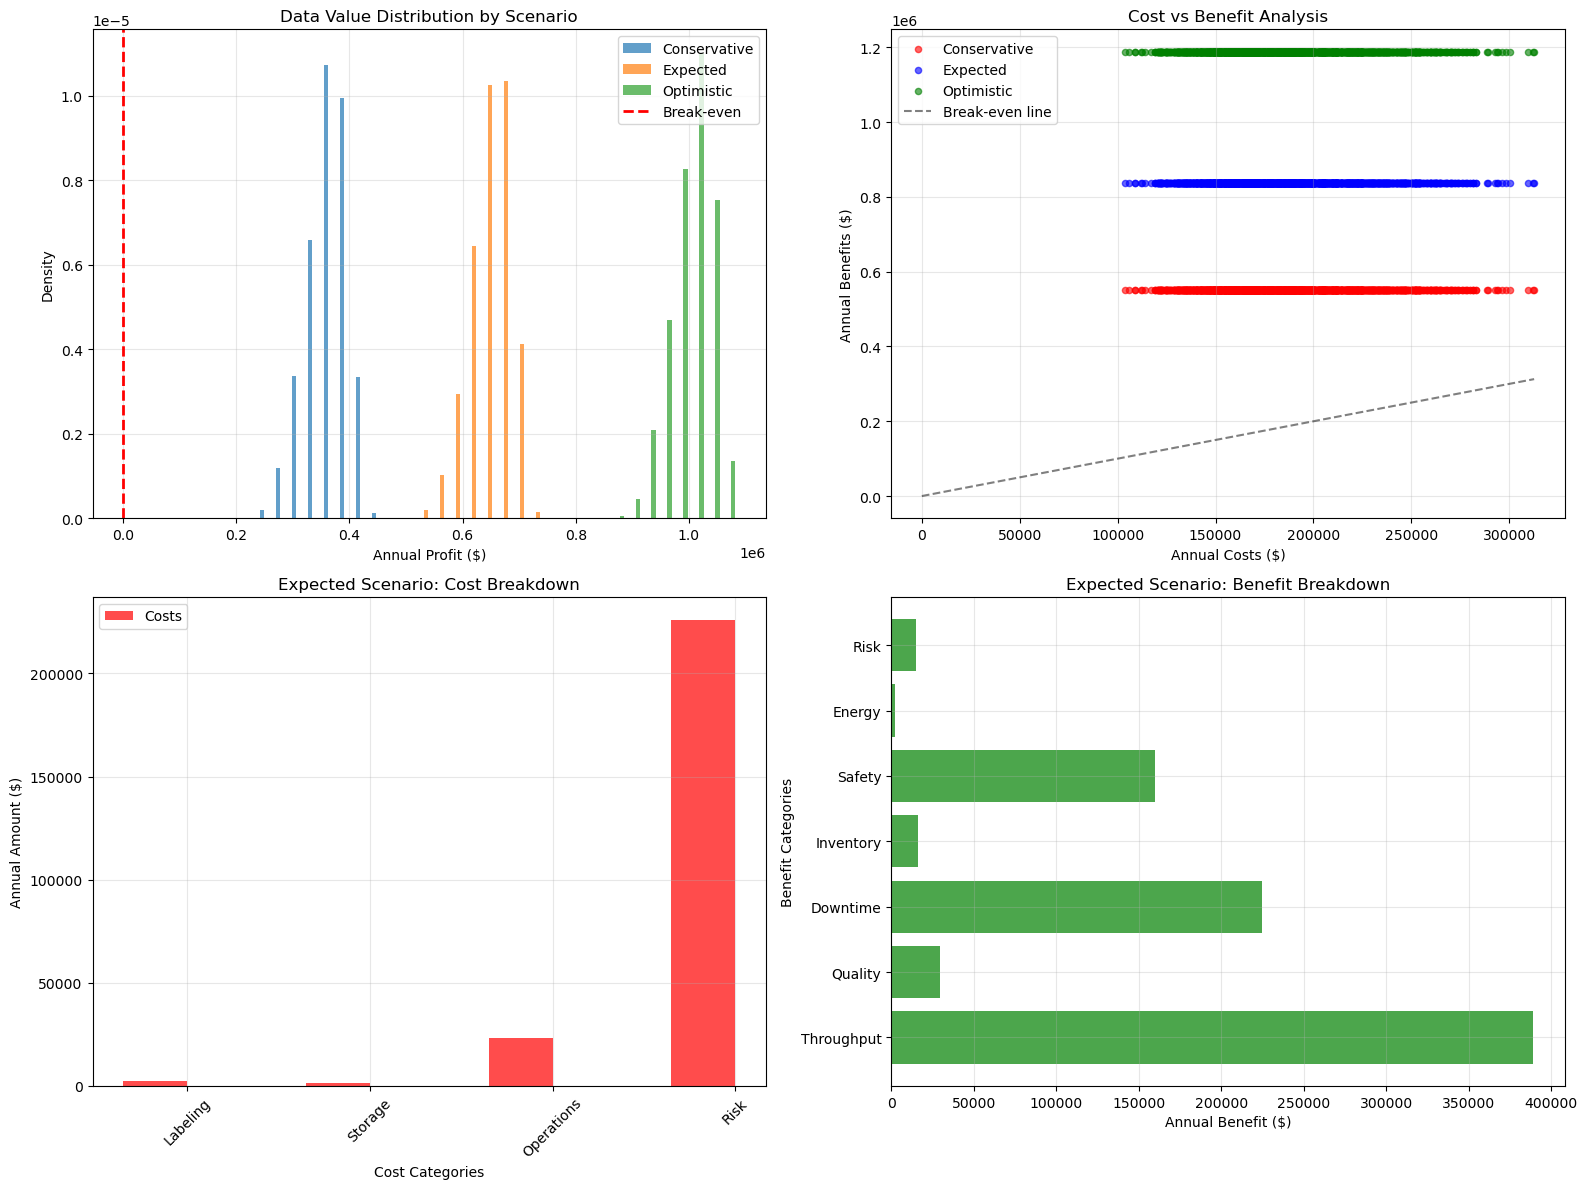

=== DATA VALUE SUMMARY TABLE ===
    Scenario Mean Profit Median Profit      P10        P90 Profit Prob Mean Costs Mean Benefits
Conservative    $365,592      $369,703 $316,200   $408,179      100.0%   $186,524      $552,116
    Expected    $650,808      $654,920 $601,417   $693,395      100.0%   $186,524      $837,332
  Optimistic  $1,002,167    $1,006,279 $952,776 $1,044,754      100.0%   $186,524    $1,188,691

=== ROI ANALYSIS ===
Conservative:
  Payback Period: 0.4 years
  1-Year ROI: 144%
  3-Year NPV: $946,775

Expected    :
  Payback Period: 0.2 years
  1-Year ROI: 334%
  3-Year NPV: $1,802,424

Optimistic  :
  Payback Period: 0.1 years
  1-Year ROI: 568%
  3-Year NPV: $2,856,502

=== KEY INSIGHTS ===
• Expected annual data value: $650,808
• Data creates positive value in 100.0% of scenarios
• Conservative scenario still profitable: $365,592
• Optimistic scenario shows high upside: $1,002,167
• Risk-adjusted analysis shows realistic data value potential
• Formula: Data Value = 

In [8]:
# === VISUALIZATIONS AND SUMMARY ===

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Profit distribution by scenario
ax1.hist([results_summary[s]['annual_profit'] for s in scenarios], 
         bins=30, alpha=0.7, label=scenarios, density=True)
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax1.set_xlabel('Annual Profit ($)')
ax1.set_ylabel('Density')
ax1.set_title('Data Value Distribution by Scenario')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Cost vs Benefit scatter
colors = ['red', 'blue', 'green']
for i, scenario in enumerate(scenarios):
    results = results_summary[scenario]
    ax2.scatter(results['annual_costs'], results['annual_benefits'], 
               alpha=0.6, s=20, color=colors[i], label=scenario)
ax2.plot([0, max([results_summary[s]['annual_costs'].max() for s in scenarios])], 
         [0, max([results_summary[s]['annual_costs'].max() for s in scenarios])], 
         'k--', alpha=0.5, label='Break-even line')
ax2.set_xlabel('Annual Costs ($)')
ax2.set_ylabel('Annual Benefits ($)')
ax2.set_title('Cost vs Benefit Analysis')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Expected scenario breakdown
expected_results = results_summary['Expected']
cost_breakdown = expected_results['cost_breakdown'].iloc[0]
benefit_breakdown = expected_results['benefit_breakdown'].iloc[0]

# Annualize costs
annual_cost_breakdown = {
    'Labeling': cost_breakdown['labeling_cost'] * 12,
    'Storage': cost_breakdown['storage_cost'] * 12,
    'Operations': cost_breakdown['operations_cost'] * 12,
    'Risk': cost_breakdown['risk_cost'] * 12
}

# Combine cost and benefit data
cost_categories = list(annual_cost_breakdown.keys())
cost_values = list(annual_cost_breakdown.values())
benefit_categories = [k.replace('_', ' ').title() for k in benefit_breakdown.keys()]
benefit_values = list(benefit_breakdown.values())

# Create stacked bar chart
x_pos = np.arange(len(cost_categories))
width = 0.35

ax3.bar(x_pos - width/2, cost_values, width, label='Costs', alpha=0.7, color='red')
ax3.set_xlabel('Cost Categories')
ax3.set_ylabel('Annual Amount ($)')
ax3.set_title('Expected Scenario: Cost Breakdown')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(cost_categories, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Benefit breakdown
benefit_x = np.arange(len(benefit_categories))
ax4.barh(benefit_x, benefit_values, alpha=0.7, color='green')
ax4.set_xlabel('Annual Benefit ($)')
ax4.set_ylabel('Benefit Categories')
ax4.set_title('Expected Scenario: Benefit Breakdown')
ax4.set_yticks(benefit_x)
ax4.set_yticklabels(benefit_categories)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("=== DATA VALUE SUMMARY TABLE ===")
print("="*60)
summary_data = []
for scenario in scenarios:
    results = results_summary[scenario]
    summary_data.append({
        'Scenario': scenario,
        'Mean Profit': f"${results['annual_profit'].mean():,.0f}",
        'Median Profit': f"${results['annual_profit'].median():,.0f}",
        'P10': f"${np.percentile(results['annual_profit'], 10):,.0f}",
        'P90': f"${np.percentile(results['annual_profit'], 90):,.0f}",
        'Profit Prob': f"{(results['annual_profit'] > 0).mean():.1%}",
        'Mean Costs': f"${results['annual_costs'].mean():,.0f}",
        'Mean Benefits': f"${results['annual_benefits'].mean():,.0f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# ROI Analysis
print("\n=== ROI ANALYSIS ===")
print("="*40)
robot_cost = 150000  # Robot + integration cost

for scenario in scenarios:
    results = results_summary[scenario]
    mean_profit = results['annual_profit'].mean()
    payback_period = robot_cost / mean_profit if mean_profit > 0 else float('inf')
    roi_1yr = (mean_profit - robot_cost) / robot_cost * 100 if mean_profit > robot_cost else -100
    
    print(f"{scenario:12}:")
    print(f"  Payback Period: {payback_period:.1f} years")
    print(f"  1-Year ROI: {roi_1yr:.0f}%")
    print(f"  3-Year NPV: ${mean_profit * 3 - robot_cost:,.0f}")
    print()

print("=== KEY INSIGHTS ===")
print("="*30)
expected_profit = results_summary['Expected']['annual_profit'].mean()
print(f"• Expected annual data value: ${expected_profit:,.0f}")
print(f"• Data creates positive value in {(results_summary['Expected']['annual_profit'] > 0).mean():.1%} of scenarios")
print(f"• Conservative scenario still profitable: ${results_summary['Conservative']['annual_profit'].mean():,.0f}")
print(f"• Optimistic scenario shows high upside: ${results_summary['Optimistic']['annual_profit'].mean():,.0f}")
print(f"• Risk-adjusted analysis shows realistic data value potential")
print(f"• Formula: Data Value = Annual Benefits - Annual Costs")
print(f"• This represents the TRUE PROFIT from your manufacturing robot data!")
